# Fuzzy Suitability Analysis
This notebook 
* calculate Euclidean distances based on criteria
* assign fuzzy membership 
* conduct fuzzy overlay (AND operator)
* filter suitable areas of interest based on 1. defined memebership degree cut-off value, 2. size of areas
* save the GeoDataFrame of polygons of suitable areas and labels of polygons as list (set P)

Note: There are still two parts that need to be figured out:
1. Select land use by categories - only land use types that are acceptable for building digesters should be in the fuzzy analysis. 
2. Including digester scale in the filter of suitable areas by size and how to represent that.

In [2]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
from scipy import ndimage
from cflp_function import store_data_to_pickle

from rasterio.features import shapes
from rtree import index
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import nearest_points

import matplotlib.pyplot as plt

## 1. Load data

Small digester criteria:
* Proximity to farm 
* Proximity to road network

In [5]:
farm = gpd.read_file(r"./raster/clip_farm.shp")
farm.head()

,IND_OBJ_KE,IND_WAARDE,IND_WAARD0,IND_OBJ_AA,IND_OBJ_NA,IND_OBJ_BE,IND_OBJ_GR,IND_PERIOD,IND_THEMA,IND_CULT_D,OBJECTID,geometry
0,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507920,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,557.0,POINT (249005.828 481581.281)
1,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,526231,hallehuisgroep (t-huisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,613.0,POINT (248872.015 480167.536)
2,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,527052,hallehuisgroep (hallehuisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,625.0,POINT (246452.085 483617.636)
3,NaN,Rijksbeschermd,NaN,Ja,9916,onbekend,boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,652.0,POINT (248704.433 479914.870)
4,NaN,Gemeentelijk monument,NaN,Ja,BOR01032,onbekend,boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,671.0,POINT (248663.461 480092.868)


In [6]:
road = gpd.read_file(r"./raster/clip_road.shp")
road.head()

,u,v,key,highway,geometry
0,356,391,0,motorway,"LINESTRING (247574.767 478133.761, 247574.751 ..."
1,356,392,0,motorway_link,"LINESTRING (247703.431 478197.122, 247710.942 ..."
2,388,501,0,secondary,"LINESTRING (244106.110 481570.317, 244127.141 ..."
3,391,430,0,motorway_link,"LINESTRING (247106.336 478783.924, 247078.913 ..."
4,391,422,0,motorway,"LINESTRING (247106.336 478783.924, 247078.025 ..."


In [7]:
road = road.to_crs("EPSG:28992")

In [8]:
src = rasterio.open(r'./raster/agri_clip.tif')
lu = src.read(1)
src.close()

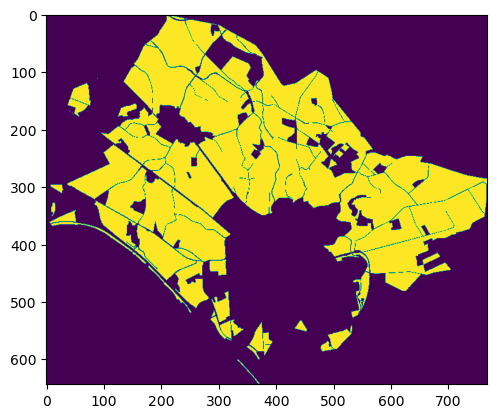

<Axes: >

In [9]:
show(lu)

In [11]:
# Load raster data
with rasterio.open(r'./raster/agri_clip.tif') as src:
    print(src.meta)
    LU = src.read(1)  # Assuming it is a single band raster

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 768, 'height': 644, 'count': 1, 'crs': CRS.from_epsg(28992), 'transform': Affine(10.0, 0.0, 243799.6719999984,
       0.0, -10.0, 484538.0309999995)}


In [12]:
LU.shape

(644, 768)

## 2. Calculate Euclidean Distances


In [13]:
# # Initialize an empty array to store the distances
# distances_farm = np.ones_like(LU) * np.inf

In [14]:
# # Iterate through each cell
# for row in range(LU.shape[0]):
#     for col in range(LU.shape[1]):
#         cell_center = src.xy(row, col)
#         point = Point(cell_center)

#         # Calculate distances to farms
#         for _, f in farm.iterrows():
#             distance = point.distance(f.geometry)
#             if distance < distances_farm[row, col]:
#                 distances_farm[row, col] = distance

In [15]:
# distances_farm.shape

In [16]:
# # Combine the distances with the original raster data
# combined_raster = LU + distances_farm

# # Visualize the combined raster
# plt.imshow(combined_raster, cmap='viridis')
# plt.colorbar()
# plt.show()

### Rtree method

In [17]:
# Create spatial indexes for farms and roads
idx_farms = index.Index()
for i, f in farm.iterrows():
    idx_farms.insert(i, f.geometry.bounds)

In [19]:
# Create a mask to identify non-zero values, the cells with zero are background cells
background_value = 0  # Adjust this if the background value is different
mask = LU != background_value

In [22]:
# Create new array in the shape of LU and fill with inf values 
distance_to_farm = np.full_like(LU, np.inf, dtype=np.float64)

In [23]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]: # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)
        # Calculate distances to nearby farms using spatial indexing
            for j in idx_farms.nearest(cell_center, 1):
                f = farm.geometry.iloc[j]
                d = point.distance(f)
                if d < distance_to_farm[row, col]:
                    distance_to_farm[row, col] = d

In [105]:
# (distances_farm==distances_f).all() 

True

In [24]:
distance_to_farm

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [25]:
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree

# Convert farm geometries to NumPy array
farm_points = np.array([(geom.x, geom.y) for geom in farm.geometry])

# Create a KDTree for fast nearest-neighbor search
tree = cKDTree(farm_points)

# Create new array in the shape of LU and fill with inf values 
d_to_farm = np.full_like(LU, np.inf, dtype=np.float64)

# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]:  # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

            # Use the KDTree to find the index of the nearest farm
            j = tree.query([cell_center], k=1)[1][0]

            f = farm.geometry.iloc[j]
            d = point.distance(f)

            if d < d_to_farm[row, col]:
                d_to_farm[row, col] = d

In [26]:
# Check if the arrays are equal
are_equal = np.array_equal(distance_to_farm, d_to_farm)

if are_equal:
    print("The arrays are equal.")
else:
    print("The arrays are not equal.")

The arrays are equal.


In [36]:
# Open the original raster file
with rasterio.open(r'./raster/agri_clip.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/d_to_farm.tif', 'w', **profile) as dst:
        dst.write(d_to_farm, 1)

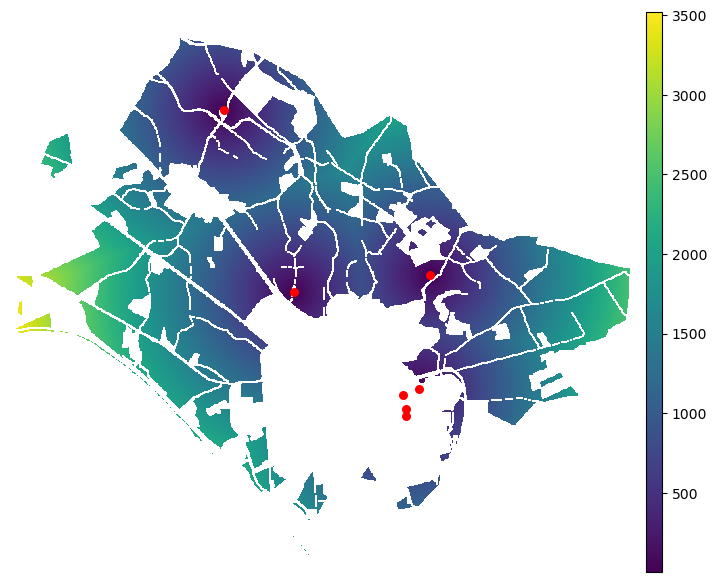

In [11]:
with rasterio.open(r'./raster/d_to_farm.tif') as src_farm:
    d_to_farm_raster = src_farm.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_farm, ax=ax)

    # Plot the farms
    farm.plot(ax=ax, marker='o', color='red', markersize=30)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')

    # Show the plot
    plt.show()

In [42]:
# if np.any(lu.read(1) > 0):
#     print("There are values larger than zero in the array.")
# else:
#     print("There are no values larger than zero in the array.")

### Distance to Road

In [43]:
# Create spatial indexes for roads
idx_roads = index.Index()
for i, r in road.iterrows():
    idx_roads.insert(i, r.geometry.bounds)

In [45]:
d_to_road = np.full_like(LU, np.inf, dtype=np.float64)

# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]: # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

        # Calculate distances to nearby farms using spatial indexing
            for j in idx_roads.nearest(cell_center, 1):
                r = road.geometry.iloc[j]
                d = point.distance(r)
                if d < d_to_road[row, col]:
                    d_to_road[row, col] = d

In [46]:
d_to_road

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [47]:
# Open the original raster file
with rasterio.open(r'./raster/agri_clip.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/d_to_road.tif', 'w', **profile) as dst:
        dst.write(d_to_road, 1)

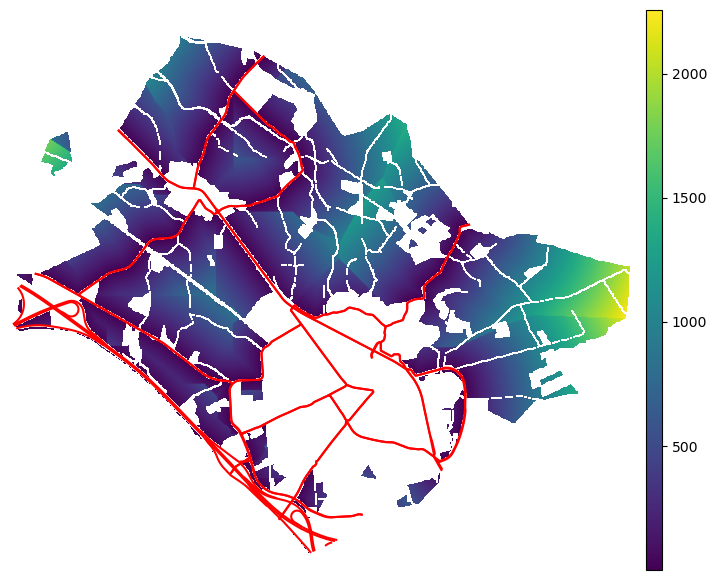

In [10]:
with rasterio.open(r'./raster/d_to_road.tif') as src_road:

    d_to_road_raster = src_road.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_road, ax=ax)

    # Plot the farms
    road.plot(ax=ax, color='red', )

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')

    # Show the plot
    plt.show()

## Fuzzy Suitability Analysis

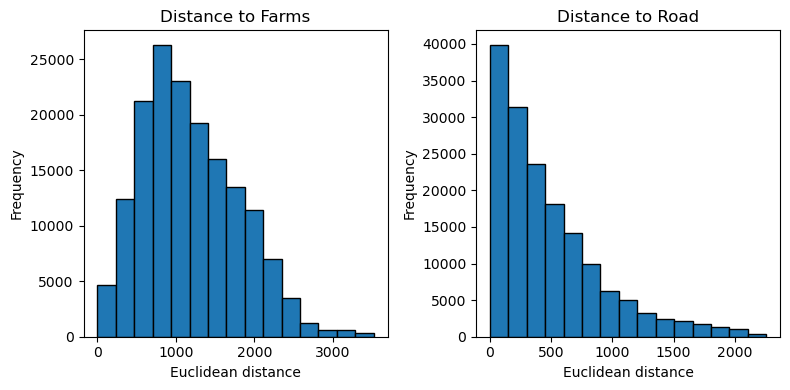

In [12]:
# Create subplots
plt.figure(figsize=(8, 4))

# Plot the first histogram
plt.subplot(1, 2, 1)
plt.hist(d_to_farm_raster[np.isfinite(d_to_farm_raster)], bins=15, edgecolor='black')
plt.title('Distance to Farms')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Plot the second histogram
plt.subplot(1, 2, 2)
plt.hist(d_to_road_raster[np.isfinite(d_to_road_raster)], bins=15, edgecolor='black')
plt.title('Distance to Road')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [17]:
d_to_farm_range = d_to_farm_raster[np.isfinite(d_to_farm_raster)] 
d_to_road_range = d_to_road_raster[np.isfinite(d_to_road_raster)]

In [19]:
len(d_to_farm_range)

160872

In [22]:
np.min(d_to_road_range), np.max(d_to_road_range)

(0.52243584, 2256.5605)

In [21]:
len(d_to_road_range)

160872

In [14]:
# Create fuzzy variables
fuzzy_farm = ctrl.Antecedent(d_to_farm_range, 'distance_to_farms')
fuzzy_road = ctrl.Antecedent(d_to_road_range, 'distance_to_roads')

In [95]:
# Define fuzzy membership functions using piecewise linear membership functions
fuzzy_farm['close'] = fuzz.piecemf(fuzzy_farm.universe, [0, 0, 5, 10], [1, 1, 0, 0])
fuzzy_farm['medium'] = fuzz.piecemf(fuzzy_farm.universe, [0, 5, 10], [0, 1, 0])
fuzzy_farm['far'] = fuzz.piecemf(fuzzy_farm.universe, [0, 5, 10, 10], [0, 0, 1, 1])


array([1049.4728, 1044.2915, 1024.2811, ..., 2102.061 , 2096.3408,
       2110.26  ], dtype=float32)

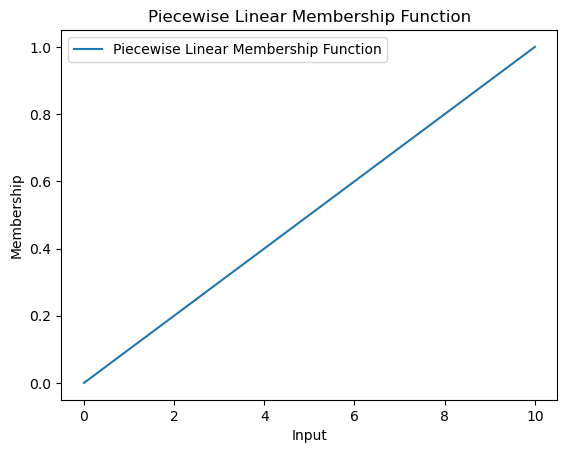

In [105]:
# Define the universe of discourse
x = np.arange(0, 11, 1)

# Define x and y coordinates for the piecewise linear function
xmf_points = [0, 5, 10]
ymf_points = [1, 0, 0]

# Create the piecewise linear membership function
membership_function = fuzz.piecemf(x, xmf_points)

# Plot the membership function
plt.plot(x, membership_function, label='Piecewise Linear Membership Function')
plt.title('Piecewise Linear Membership Function')
plt.xlabel('Input')
plt.ylabel('Membership')
plt.legend()
plt.show()

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


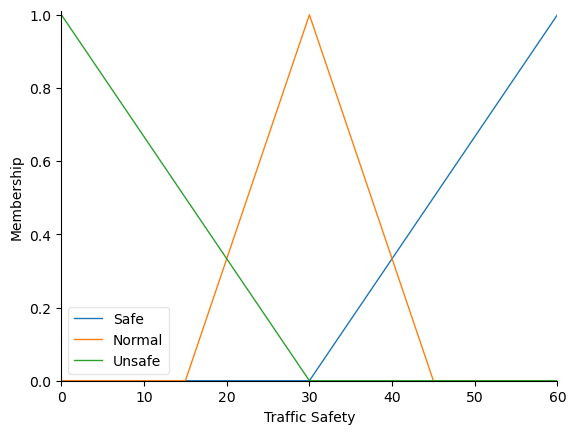

In [112]:
traffic_safety = ctrl.Antecedent(np.arange(0, 61, 1), 'Traffic Safety')
traffic_safety['Safe'] = fuzz.trimf(traffic_safety.universe, [30, 60, 60])
traffic_safety['Normal'] = fuzz.trimf(traffic_safety.universe, [15, 30, 45])
traffic_safety['Unsafe'] = fuzz.trimf(traffic_safety.universe, [0, 0, 30])
traffic_safety.view() 

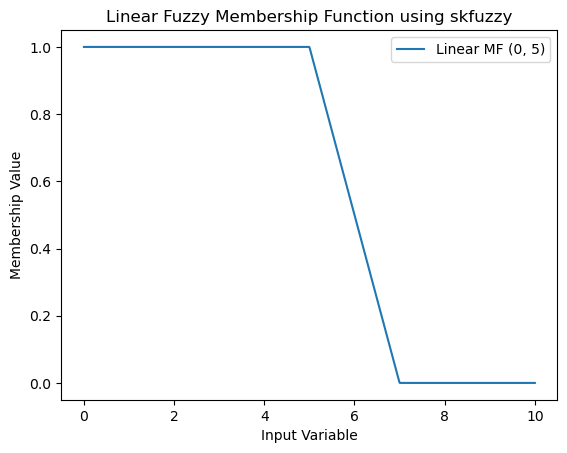

In [141]:
# Generate universe variables
x = np.linspace(0, 10, 1000)

# Generate the fuzzy membership function
a = 0
b = 5
c = 7
linear_mf = fuzz.trapmf(x, [a, a, b, c])

# Plot the membership function
plt.plot(x, linear_mf, label=f'Linear MF ({a}, {b})')
plt.title('Linear Fuzzy Membership Function using skfuzzy')
plt.xlabel('Input Variable')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

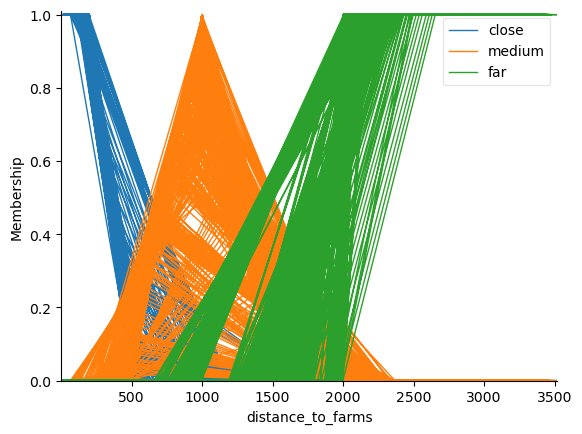

In [157]:
fuzzy_farm = ctrl.Antecedent(d_to_farm_range, 'distance_to_farms')

# # Create an Antecedent (input variable)
# fuzzy_farm = ctrl.Antecedent(np.linspace(0, 10, 100), 'FuzzyFarm')

# # Define parameters for the trapezoidal membership function
# a, b, c, d = 100, 500, 2000, np.max(d_to_farm_range)

# Define fuzzy sets
fuzzy_farm['close'] = fuzz.trapmf(fuzzy_farm.universe, [0, 0, 200, 500])
fuzzy_farm['medium'] = fuzz.trimf(fuzzy_farm.universe, [500, 1000, 1500])
fuzzy_farm['far'] = fuzz.trapmf(fuzzy_farm.universe, [2000, 2000, np.max(d_to_farm_range), np.max(d_to_farm_range)])

fuzzy_farm.view()

# # Plot the membership function
# plt.plot(x, linear_mf, label=f'Linear MF ({a}, {b})')
# plt.title('Linear Fuzzy Membership Function using skfuzzy')
# plt.xlabel('Input Variable')
# plt.ylabel('Membership Value')
# plt.legend()
# plt.show()

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


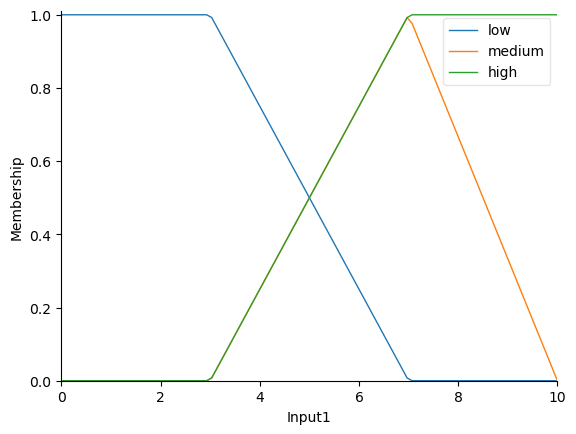

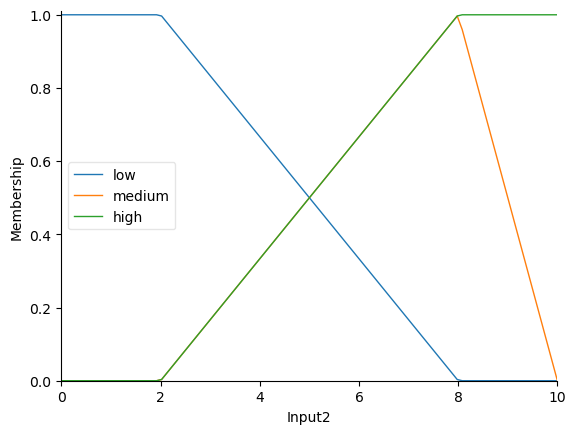

In [15]:
# Create Antecedents (input variables)
input1 = ctrl.Antecedent(np.linspace(0, 10, 100), 'Input1')
input2 = ctrl.Antecedent(np.linspace(0, 10, 100), 'Input2')

# Define fuzzy membership functions for the inputs
a1, b1 = 3, 7
input1['low'] = fuzz.trapmf(input1.universe, [0, 0, a1, b1])
input1['medium'] = fuzz.trimf(input1.universe, [a1, b1, 10])
input1['high'] = fuzz.trapmf(input1.universe, [a1, b1, 10, 10])
input1.view() 

a2, b2 = 2, 8
input2['low'] = fuzz.trapmf(input2.universe, [0, 0, a2, b2])
input2['medium'] = fuzz.trimf(input2.universe, [a2, b2, 10])
input2['high'] = fuzz.trapmf(input2.universe, [a2, b2, 10, 10])
input2.view() 

# Example usage:
input1_value = 5
input2_value = 6

In [57]:
# # Your farm and road arrays
# farm_distances = np.array(...)  # Replace ... with your actual farm distances array
# road_distances = np.array(...)  # Replace ... with your actual road distances array

# Farm distance
farm_distance = ctrl.Antecedent(d_to_farm_range, 'farm_distance')
farm_distance['close'] = fuzz.trimf(farm_distance.universe, [d_to_farm_range.min(), 100, 500])  # Adjust some_value based on your data
farm_distance['medium'] = fuzz.trimf(farm_distance.universe, [450, 750, 1000])
farm_distance['far'] = fuzz.trimf(farm_distance.universe, [750, 1000, d_to_farm_range.max()])

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


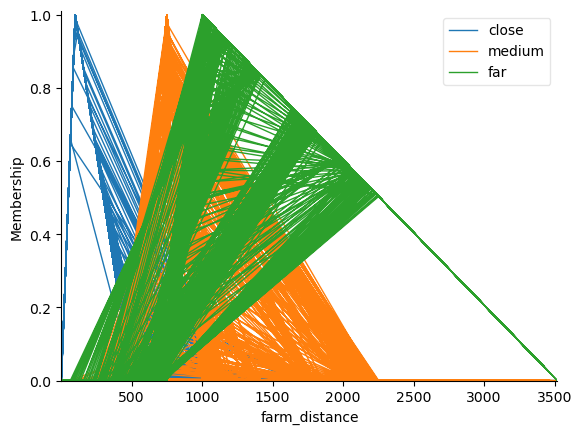

In [46]:
farm_distance.view()

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


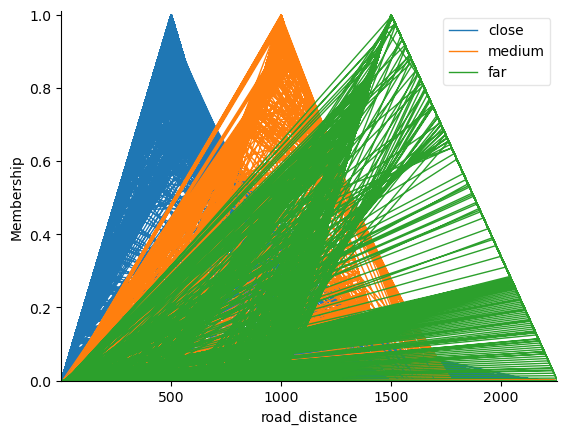

In [58]:
# Road distance
road_distance = ctrl.Antecedent(d_to_road_range, 'road_distance')
road_distance['close'] = fuzz.trimf(road_distance.universe, [d_to_road_range.min(), 500, 1000])  # Adjust some_value based on your data
road_distance['medium'] = fuzz.trimf(road_distance.universe, [500, 1000, 1500])
road_distance['far'] = fuzz.trimf(road_distance.universe, [1000, 1500, d_to_road_range.max()])
road_distance.view()

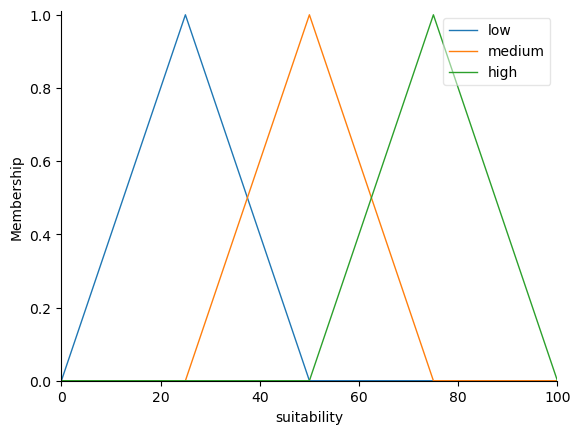

In [59]:
# Suitability
suitability = ctrl.Consequent(np.arange(0, 101, 1), 'suitability')
suitability['low'] = fuzz.trimf(suitability.universe, [0, 25, 50])
suitability['medium'] = fuzz.trimf(suitability.universe, [25, 50, 75])
suitability['high'] = fuzz.trimf(suitability.universe, [50, 75, 100])
suitability.view()

In [60]:
rule1 = ctrl.Rule(farm_distance['close'] & road_distance['close'], suitability['high'])
rule2 = ctrl.Rule(farm_distance['medium'] & road_distance['medium'], suitability['medium'])
rule3 = ctrl.Rule(farm_distance['far'] & road_distance['far'], suitability['low'])
# rule4 = ctrl.Rule(farm_distance['medium'] & road_distance['far'], suitability['low'])
# rule5 = ctrl.Rule(farm_distance['far'] & road_distance['medium'], suitability['low'])
# rule6 = ctrl.Rule(farm_distance['close'] & road_distance['medium'], suitability['medium'])
# rule6 = ctrl.Rule(farm_distance['medium'] & road_distance['close'], suitability['medium'])

In [61]:
# Create the fuzzy control system and add the rules:
suitability_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
suitability_evaluator = ctrl.ControlSystemSimulation(suitability_ctrl)

In [43]:
d_to_road_range[100]

887.26013

In [171]:
# suitability_evaluator.input['farm_distance'] = d_to_farm_range[100]
# suitability_evaluator.input['road_distance'] = d_to_road_range[100]

# suitability_evaluator.compute()

In [75]:
fuzzy_farm = np.maximum(0, 1 - (d_to_farm_range - d_to_farm_range.min()) / (d_to_farm_range.max() - d_to_farm_range.min()))

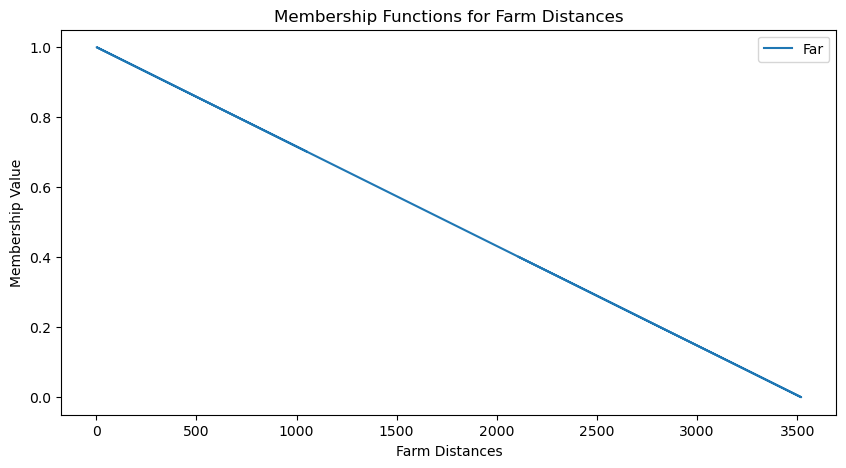

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(d_to_farm_range, fuzzy_farm, label='Far')
plt.title('Membership Functions for Farm Distances')
plt.xlabel('Farm Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

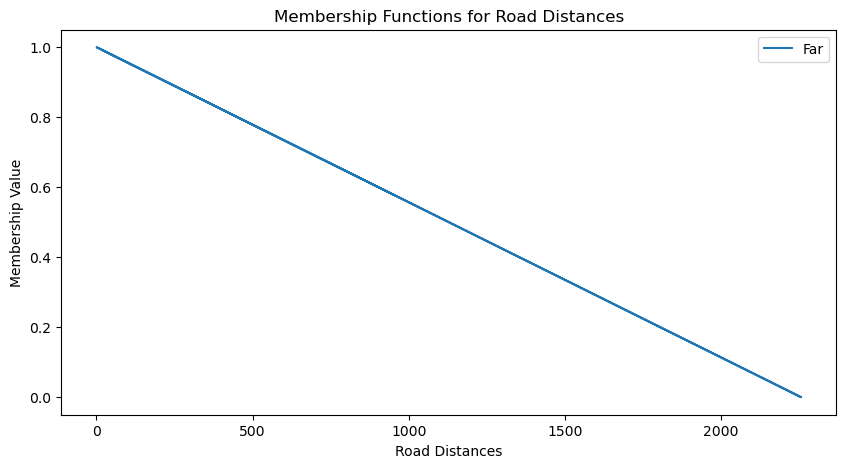

In [78]:
fuzzy_road = np.maximum(0, 1 - (d_to_road_range - d_to_road_range.min()) / (d_to_road_range.max() - d_to_road_range.min()))
plt.figure(figsize=(10, 5))
plt.plot(d_to_road_range, fuzzy_road, label='Far')
plt.title('Membership Functions for Road Distances')
plt.xlabel('Road Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

In [83]:
# Fuzzy operation AND
fuzzy_and = np.minimum(fuzzy_farm, fuzzy_road)

In [132]:
# Find indices where array0 is not inf
non_inf_indices = np.where(np.isfinite(d_to_farm_raster))
non_inf_indices

(array([  2,   2,   2, ..., 642, 642, 643]),
 array([210, 211, 215, ..., 370, 371, 370]))

In [135]:
assert len(fuzzy_and) == len(non_inf_indices[0])

In [136]:
m = np.copy(d_to_farm_raster)

In [137]:
# Replace values in result_array with corresponding values from array1
m[non_inf_indices] = fuzzy_and

In [143]:
# Open the original raster file
with rasterio.open(r'./raster/agri_clip.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/fuzzy_and_1.tif', 'w', **profile) as dst:
        dst.write(m, 1)

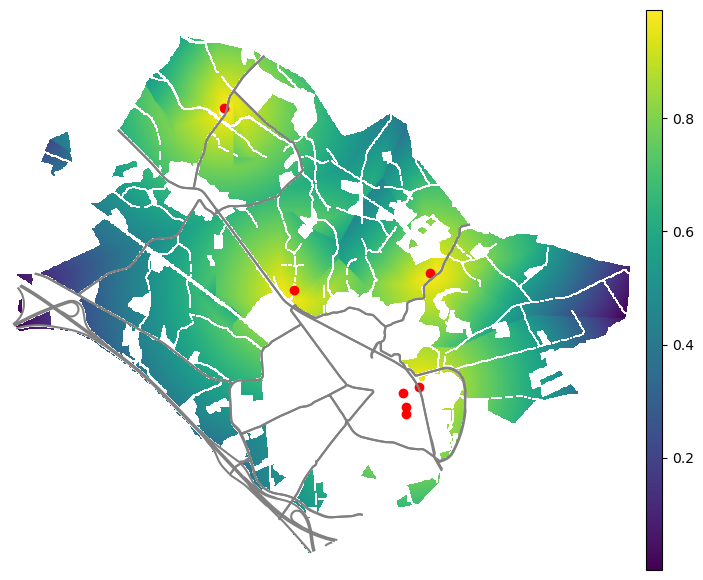

In [146]:
with rasterio.open(r'./raster/fuzzy_and_1.tif') as src:

    fuzzy = src.read(1)
 
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)

    road.plot(ax=ax, color='grey')
    farm.plot(ax=ax, color='red')

    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')
    plt.show()

### Processing Suitable Areas
Now we have a raster layer that indicates how suitable a cell for building digester. We have to somehow process this data into set Plant as the CFLP model input. Set Plant should be node osmid.
* Filter by area requirement 
* Append to nodes

In [7]:
n = gpd.read_file(r"./raster/clip_node.shp")
n.head()

,osmid,y,x,lon,lat,highway,geometry
0,391,6.852609e+06,749985.068617,6.737230,52.289324,motorway_junction,POINT (247106.336 478783.924)
1,421,6.852019e+06,750489.245723,6.741760,52.286082,motorway_junction,POINT (247422.054 478428.975)
2,422,6.853062e+06,749313.366809,6.731197,52.291813,NaN,POINT (246689.562 479053.139)
3,429,6.852456e+06,749798.452623,6.735554,52.288483,NaN,POINT (246993.714 478688.167)
4,430,6.853370e+06,749330.907112,0.000000,0.000000,NaN,POINT (246696.821 479241.477)


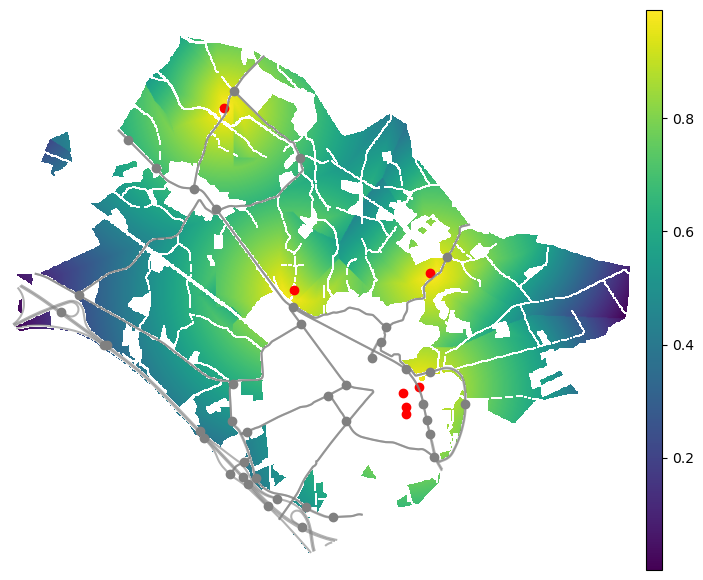

In [8]:
with rasterio.open(r'./raster/fuzzy_and_1.tif') as src:

    fuzzy = src.read(1)
    transform = src.transform
 
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)

    road.plot(ax=ax, color='grey', alpha=0.6)
    farm.plot(ax=ax, color='red')
    n.plot(ax=ax, color='grey')

    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')
    plt.show()

In [9]:
s_area_min = 500
s_area_max = 1000 #m2, which = 1ha

In [10]:
# Define a cut off suitability value to filter areas
cut_off = 0.8

In [11]:
# Create a binary mask based on the criteria
mask = ((fuzzy >= cut_off) & np.isfinite(fuzzy))

# Label connected components in the mask
 
label_map, num_labels = ndimage.label(mask) # num_labels - the total number of labels or connected components found in the binary mask.
    # adjacent elements along any dimension are considered connected
    # ndimage.label is a powerful tool for segmenting and identifying distinct regions in binary images, 
    # making it useful in various image processing and computer vision applications.

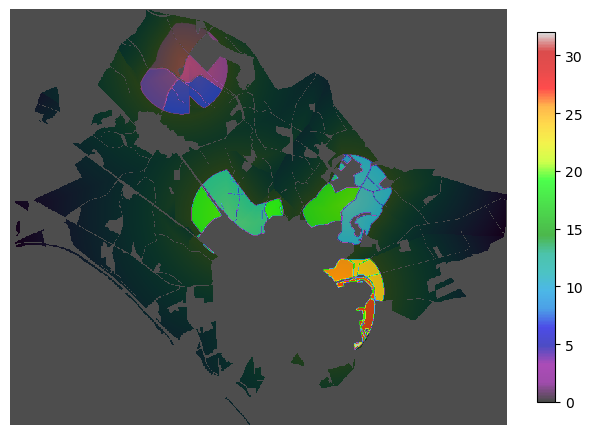

In [12]:
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none')

# Visualize the labeled components
plt.imshow(label_map, cmap='nipy_spectral', alpha=0.7)

plt.colorbar(shrink=0.6)
plt.axis('off')
plt.show()

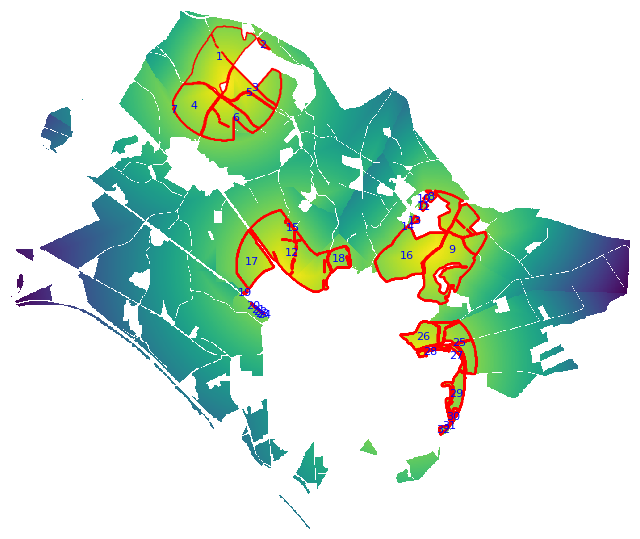

In [13]:
# Set the figure size
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none', cmap='viridis')

# Visualize the labeled components with contours
contours = plt.contour(label_map, levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1)

# Add labels for each connected component at the centroid
for label in range(1, num_labels + 1):
    indices = np.argwhere(label_map == label)
    centroid = np.mean(indices, axis=0)
    plt.text(centroid[1], centroid[0], str(label), color='blue', fontsize=8, ha='center', va='center')

# # Customize the colorbar
# colorbar = plt.colorbar(shrink=0.8)

# Remove the axis ticks
plt.axis('off')

plt.show()

In [14]:
# Calculate the area of each labeled component
area_sizes = ndimage.sum(mask, label_map, range(num_labels + 1))

# Identify areas meeting the size criteria
valid_areas = np.where((area_sizes >= s_area_min) & (area_sizes <= s_area_max))[0]

# Create a mask for the valid areas
valid_areas_mask = np.isin(label_map, valid_areas)
np.any(valid_areas_mask)

True

In [15]:
# print(n.crs)
# with rasterio.open('./raster/fuzzy_and_1.tif') as src:
#     print(src.crs)

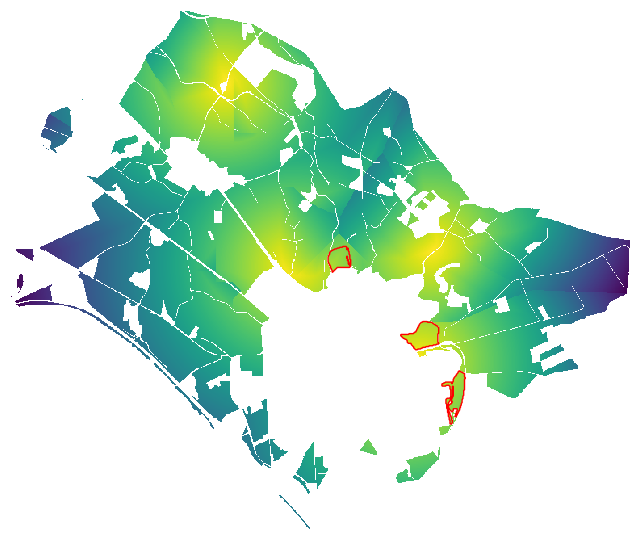

In [16]:
# Set the figure size
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none', cmap='viridis', zorder=1)

# Visualize the labeled components with contours
contours = plt.contour(valid_areas_mask, levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1)

# # Customize the colorbar
# colorbar = plt.colorbar(shrink=0.8)

# Remove the axis ticks
plt.axis('off')

plt.show()

In [17]:
# Check the extent of the GeoDataFrame
print(n.total_bounds)

# Check the extent of the raster
with rasterio.open('./raster/fuzzy_and_1.tif') as src:
    print(src.bounds)

[244431.74174497 478428.97546287 249437.64587518 483836.6254033 ]
BoundingBox(left=243799.6719999984, bottom=478098.0309999995, right=251479.6719999984, top=484538.0309999995)


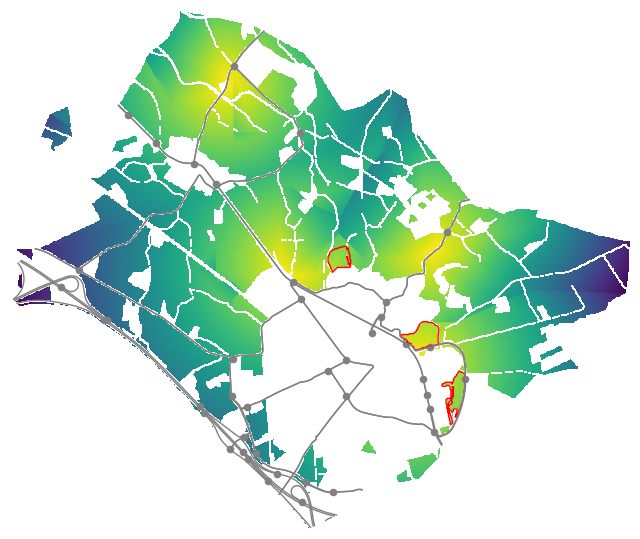

In [33]:
with rasterio.open('./raster/fuzzy_and_1.tif') as src:
    fuzzy = src.read(1)
    transform = src.transform

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the raster using imshow
    ax.imshow(fuzzy, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Plot contours ([::-1, :] to flip the array vertically before plotting)
    contours = plt.contour(valid_areas_mask[::-1, :], levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Plot the GeoDataFrame
    n.plot(ax=ax, color='grey', markersize = 20)
    road.plot(ax=ax, color='grey', zorder=2, linewidth =1)

    ax.axis('off')
    plt.show()

### Prepare suitable areas as set Plant

In [19]:
label_component, num_labels_component = ndimage.label(valid_areas_mask)

In [20]:
polygons = []
# Iterate through each label and convert it to a polygon
for label in range(1, num_labels_component + 1):
    mask = label_component == label
    shape_info = next(shapes(mask.astype(np.uint8), mask=mask, transform=transform))
    # Extract each set of coordinates and create a Shapely Polygon
    coordinates_list = shape_info[0]['coordinates']
    polygons.append((label, MultiPolygon([Polygon(coords) for coords in coordinates_list])))

In [21]:
polygons

[(1,
  <MULTIPOLYGON (((247919.672 481598.031, 247919.672 481588.031, 247879.672 48...>),
 (2,
  <MULTIPOLYGON (((248909.672 480668.031, 248909.672 480658.031, 248889.672 48...>),
 (3,
  <MULTIPOLYGON (((249359.672 480058.031, 249359.672 480048.031, 249349.672 48...>)]

In [22]:
# Create a GeoDataFrame from the list of polygons
polygon_gdf = gpd.GeoDataFrame(polygons, columns=['Label', 'Coordinates'], geometry='Coordinates', crs=n.crs)

<Axes: >

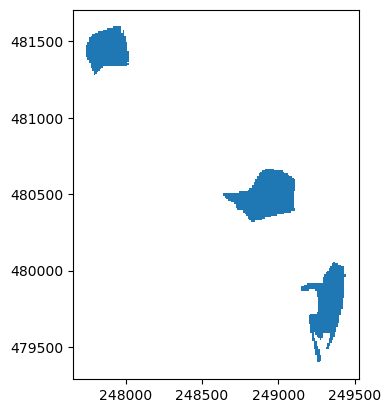

In [23]:
polygon_gdf.plot()

Maybe it is not necessary to get polygons of suitable areas. A centroid will suffice for finding nearest node. But perhaps polygon is nice for visualization. 

In [24]:
polygon_gdf.to_file(r'./raster/suitable_polygons_gdf.shp')

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_51213/1851650195.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygon_gdf.to_file(r'./raster/suitable_polygons_gdf.shp')


In [34]:
polygon_gdf['centroid'] = polygon_gdf['Coordinates'].centroid

In [75]:
# Find the closest node in n for each centroid
# polygon_gdf['closest_point'] = polygon_gdf['centroid'].apply(
#     #lambda centroid: nearest_points(centroid, n.unary_union)[1]
#     lambda centroid: n.loc[nearest_points(centroid, n.unary_union)[1].coords[0]]['osmid']
# )

polygon_gdf['closest_osmid'] = polygon_gdf['centroid'].apply(
    lambda centroid: n.loc[n['geometry'] == nearest_points(centroid, n.unary_union)[1], 'osmid'].iloc[0]
    # lambda centroid: n.loc[nearest_points(centroid, n.unary_union)[1].x, 'osmid']
)

In [79]:
Plant = polygon_gdf['closest_osmid'].tolist()

In [82]:
folder_path = 'app_data'

In [83]:
store_data_to_pickle(Plant, folder_path, 'Plant.pickle') # set P